In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import os
import copy
from sklearn.linear_model import LogisticRegression
sns.set(style = "darkgrid")
%matplotlib inline

In [135]:
train_dataset_path = os.getcwd() + '/mnist_data/mnist_csv/mnist_train.csv'
test_dataset_path = os.getcwd() + '/mnist_data/mnist_csv/mnist_test.csv'

In [136]:
train_set = pd.read_csv(train_dataset_path, sep=',')
test_set = pd.read_csv(test_dataset_path, sep=',')

train_set = train_set.sample(frac=1, axis=0, random_state=0)
train_set.reset_index(drop=True, inplace=True)

test_set = test_set.sample(frac=1, axis=0, random_state=0)
test_set.reset_index(drop=True, inplace=True)

train_set = train_set.to_numpy()
test_set = test_set.to_numpy()

In [137]:
X_train = train_set[:, 1:]
y_train = train_set[:, 0]
X_test = test_set[:, 1:]
y_test = test_set[:, 0]

In [138]:
print('Training set:', X_train.shape)
print('Test set:', X_test.shape)

Training set: (60000, 784)
Test set: (10000, 784)


In [139]:
X_train[X_train < 127] = 0
X_train[X_train >= 127] = 1
X_test[X_test < 127] = 0
X_test[X_test >= 127] = 1

### MNIST
>Implement an L1 and L2 regularized logistic regression model using the scikit-learn library. 

In [140]:
### L1 Regularization

def L1_logistic_reg(X_train, y_train, X_test, y_test):
    digits = np.arange(10)

    acc = np.zeros((10, 2))
    
    for i in digits:
        y1 = np.zeros(y_train.shape[0])
        y2 = np.zeros(y_test.shape[0])
    
        pos_y = np.where(y_train == i)[0]    
        y1[pos_y] = 1 # positive class

        pos_y = np.where(y_test == i)[0]    
        y2[pos_y] = 1 # positive class

        clf2 = LogisticRegression(penalty='l1', tol=0.001, fit_intercept=True, max_iter=50,
                                 random_state=0, solver='saga', n_jobs=-1, multi_class='auto')

        clf2.fit(X_train, y1)
        print('Train: ', clf2.score(X_train, y1))
        print('Test: ', clf2.score(X_test, y2))
        
        acc[i, :] = [i, clf2.score(X_test, y2)]
        print(acc[i, :])
        
    return pd.DataFrame(acc, columns=['digit', 'accuracy'])

In [141]:
def roc_curve(data, label, digit, proba, nthres):
   
    prb = pd.DataFrame(proba)
    org_labels = pd.DataFrame(label, columns=['class'])
    dt = pd.concat([prb, org_labels], axis = 1)
    thresholds = np.linspace(0, 1, num = nthres)
    
    roc_points = pd.DataFrame(columns = ['class', 'FPR', 'TPR']) # class, fpr, tpr
    
    for thres in thresholds:
        tp = 0
        fp = 0
        fn = 0
        tn = 0

        tp = dt.loc[(dt[1] > thres) & (dt['class'] == 1)].shape[0] # 1 is ositive class for digit 
        fp = dt.loc[dt[1] > thres].shape[0] - tp

        tn = dt.loc[(dt[1] < thres) & (dt['class'] != 1)].shape[0]
        fn = dt.loc[dt[1] < thres].shape[0] - tn

        if (fp == 0):
            if(tp == 0):
                pts = np.array([1, 0, 0])
            else:
                pts = np.array([1, 0, tp/(tp+fn)])
        elif (tp == 0):
            if(fp == 0):
                pts = np.array([1, 0, 0])
            else:
                pts = np.array([1, fp/(fp+tn), 0])
        else:
            pts = np.array([1,fp/(fp+tn), tp/(tp+fn)])

        roc_points = roc_points.append(pd.Series(pts, index = ['class', 'FPR', 'TPR']), ignore_index = True)
    
    roc_points['class'] = digit
    return roc_points
    

In [144]:
### L2 Regularization

def L2_logistic_reg(X_train, y_train, X_test, y_test):
    digits = np.arange(10)

    acc = np.zeros((10, 2))
    nthres = 100
    roc_pts = pd.DataFrame(columns=['class', 'FPR', 'TPR'])
    
    for i in digits:
        y1 = np.zeros(y_train.shape[0])
        y2 = np.zeros(y_test.shape[0])
    
        pos_y = np.where(y_train == i)[0]    
        y1[pos_y] = 1 # positive class

        pos_y = np.where(y_test == i)[0]    
        y2[pos_y] = 1 # positive class

        clf2 = LogisticRegression(penalty='l2', tol=0.001, max_iter=200, fit_intercept=True, verbose=1,
                                 random_state=0, solver='saga', n_jobs=-1, multi_class='auto')

        clf2.fit(X_train, y1)
        print('Train: ', clf2.score(X_train, y1))
        print('Test: ', clf2.score(X_test, y2))
        
        acc[i, :] = [i, clf2.score(X_test, y2)]
        print(acc[i, :])
        roc_one_class = roc_curve(X_test, y2, i, clf2.predict_proba(X_test), nthres)
        roc_pts = pd.concat([roc_pts, roc_one_class], axis=0)
    
    return pd.DataFrame(acc, columns=['digit', 'accuracy']), roc_pts


In [145]:
result, roc_pts = L2_logistic_reg(X_train, y_train, X_test, y_test)
result

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 195 epochs took 107 seconds
Train:  0.99345
Test:  0.9911


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


[0.     0.9911]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 180 epochs took 101 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.7min finished


Train:  0.9930333333333333
Test:  0.993
[1.    0.993]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 189 epochs took 101 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.7min finished


Train:  0.98105
Test:  0.979
[2.    0.979]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 151 epochs took 83 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.4min finished


Train:  0.9764833333333334
Test:  0.976
[3.    0.976]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 193 epochs took 107 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


Train:  0.9844833333333334
Test:  0.9819
[4.     0.9819]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 181 epochs took 119 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.0min finished


Train:  0.9750833333333333
Test:  0.9747
[5.     0.9747]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 115 seconds
Train:  0.98865


/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.9min finished


Test:  0.9835
[6.     0.9835]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 185 epochs took 107 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


Train:  0.9856666666666667
Test:  0.9836
[7.     0.9836]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 198 epochs took 114 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.9min finished


Train:  0.9606833333333333
Test:  0.9603
[8.     0.9603]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 110 seconds
Train:  0.9656833333333333


/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


Test:  0.9631
[9.     0.9631]


,digit,accuracy
0,0.0,0.9911
1,1.0,0.9930
2,2.0,0.9790
3,3.0,0.9760
4,4.0,0.9819
5,5.0,0.9747
6,6.0,0.9835
7,7.0,0.9836
8,8.0,0.9603
9,9.0,0.9631


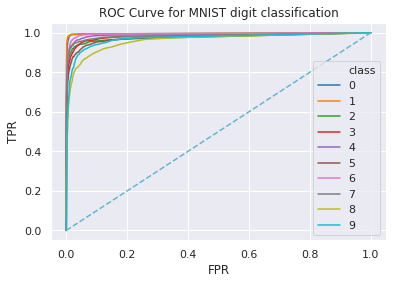

In [147]:
roc_pts['class'] = roc_pts['class'].astype('int8')
ax = sns.lineplot(x = 'FPR', y = 'TPR', data = roc_pts, legend = 'full', hue='class', palette = 'tab10')
ax.set_title('ROC Curve for MNIST digit classification')
plt.plot([0,1],[0,1],'--c')
plt.savefig('roc')
plt.show()

In [143]:
result2 = L1_logistic_reg(X_train, y_train, X_test, y_test)
result2

/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train:  0.9932833333333333
Test:  0.9917
[0.     0.9917]


/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train:  0.9926833333333334
Test:  0.9935
[1.     0.9935]


/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train:  0.98065
Test:  0.9792
[2.     0.9792]


/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train:  0.9763
Test:  0.9763
[3.     0.9763]


/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train:  0.9838833333333333
Test:  0.9819
[4.     0.9819]


/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train:  0.9754166666666667
Test:  0.9749
[5.     0.9749]


/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train:  0.9881
Test:  0.9842
[6.     0.9842]


/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train:  0.9854666666666667
Test:  0.9837
[7.     0.9837]


/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train:  0.96015
Test:  0.96
[8.   0.96]


/home/mayank/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train:  0.9657833333333333
Test:  0.9636
[9.     0.9636]


,digit,accuracy
0,0.0,0.9917
1,1.0,0.9935
2,2.0,0.9792
3,3.0,0.9763
4,4.0,0.9819
5,5.0,0.9749
6,6.0,0.9842
7,7.0,0.9837
8,8.0,0.9600
9,9.0,0.9636
